In [2]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df_bank = pd.read_csv('bank-full.csv', delimiter=';')
print("Dimesión data set",df_bank.shape)
df_bank.head(5)

Dimesión data set (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [66]:
print("Tipos datos", df_bank.dtypes)
df_bank[df_bank['poutcome'] != 'unknown']
df_success = df_bank[df_bank['y'] == 'yes']
df_no_success = df_bank[df_bank['y'] == 'no']

print("Muestras de exito ",df_success.shape, "Muestras de no éxito",df_no_success.shape)

Tipos datos age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object
Muestras de exito  (5289, 17) Muestras de no éxito (39922, 17)


In [63]:
df_bank['job'].describe()

count           4521
unique            12
top       management
freq             969
Name: job, dtype: object

In [73]:
df_bank[df_bank['pdays'] == -1].shape

(36954, 17)

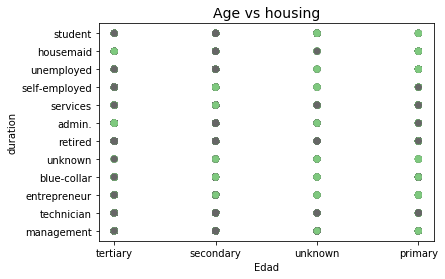

In [70]:
out = df_bank["y"]
out = out.replace("no", 0)
out = out.replace("yes", 1)
x = df_bank["education"]
y = df_bank["job"]

#_ = sns.swarmplot(x='duration', y='age', data=df_bank)
#plt.hist(y)
# Label the axes
plt.title('Age vs housing', fontsize=14)
plt.xlabel('Edad')
plt.ylabel('duration')
plt.scatter(x,y,c=out,cmap="Accent")
plt.show()

In [ ]:
sns.set(style="whitegrid")
ax = sns.swarmplot(x="housing", y="age", data=df_bank)

In [34]:
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64